In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [125]:
# torch.manual_seed(42)

In [126]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'device: {device}')

device: cuda:1


In [127]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,t):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,t], dim = 1)    #(10000,2)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)


            
        b = self.linears[-1](a) 
         
        return b
    
    # def forward_direct(self, x):
        
    #     z = x.float()
    #     H = self.linears[0].weight

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)
    #         z = self.activation(L)
    #         G = (1-torch.square(z))*H.t() #\sigma'(L)*H
    #         H = torch.matmul(self.linears[i+1].weight,G.t())

    #     z = self.linears[-1](z)
         
    #     return z,H

In [128]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [129]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [130]:
# Create the training data

x = torch.linspace(-1,1,300, requires_grad = True).view(-1,1)
t = torch.linspace(0,1,300, requires_grad = True).view(-1,1)


if torch.is_tensor(x) != True:         
    x = torch.from_numpy(x)  
if torch.is_tensor(t) != True:         
    t = torch.from_numpy(t) 

#convert to float
x = x.float()
t = t.float()

    
x_train,t_train = torch.meshgrid(x.squeeze(),t.squeeze(), indexing = 'xy')
x_train = x_train.reshape(-1,1).to(device).requires_grad_(True)     # 10000 x 1
t_train = t_train.reshape(-1,1).to(device).requires_grad_(True)     # 10000 x 1

# x_train = x_train.reshape(-1,1).requires_grad_(True)     # 10000 x 1
# t_train = t_train.reshape(-1,1).requires_grad_(True)     # 10000 x 1



In [131]:
def pde_residual(x, t, nu):
    u = PINN(x,t)

    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    du_dx_x = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

    res_pde = du_dt - (nu / (np.pi)) * du_dx_x + u * du_dx

    return res_pde


    

In [132]:

def initial_condition(x):
  u_ic = PINN(x, torch.zeros_like(x))
  res_ic = u_ic - (-torch.sin(np.pi * x))
  return res_ic

In [133]:
def boundary_condition(t):
    u_left = PINN(torch.full_like(t, -1), t)
    u_right = PINN(torch.full_like(t, 1), t)

    res_left = u_left - torch.zeros_like(t)
    res_right = u_right - torch.zeros_like(t)

    return res_left, res_right

In [134]:
def compute_losses():
   res_pde = pde_residual(x_train, t_train, nu = 0.01) 
   res_ic = initial_condition(x_train)
   res_left, res_right = boundary_condition(t_train)

   loss_pde = torch.mean(res_pde**2)
   loss_ic = torch.mean(res_ic**2)
   loss_bc = torch.mean(res_left**2) + torch.mean(res_right**2)

   total_loss = loss_pde + loss_ic + loss_bc

   return total_loss



In [177]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








Epoch 0, Loss: 0.8078573942184448
Epoch 200, Loss: 0.1330307573080063
Epoch 400, Loss: 0.10940802842378616
Epoch 600, Loss: 0.06939719617366791
Epoch 800, Loss: 0.10845814645290375
Epoch 1000, Loss: 0.05622204393148422
Epoch 1200, Loss: 0.19560980796813965
Epoch 1400, Loss: 0.07170343399047852
Epoch 1600, Loss: 0.20102903246879578
Epoch 1800, Loss: 0.12149399518966675
Epoch 2000, Loss: 0.2110915184020996
Epoch 2200, Loss: 0.060275670140981674
Epoch 2400, Loss: 0.08964341878890991
Epoch 2600, Loss: 0.1610204130411148
Epoch 2800, Loss: 0.026023177430033684
Epoch 3000, Loss: 0.1063586100935936
Epoch 3200, Loss: 0.04712590575218201
Epoch 3400, Loss: 0.17666521668434143
Epoch 3600, Loss: 0.06978660076856613
Epoch 3800, Loss: 0.11354005336761475
Epoch 4000, Loss: 0.11380163580179214
Epoch 4200, Loss: 0.04873565584421158
Epoch 4400, Loss: 0.059562161564826965
Epoch 4600, Loss: 0.027526339516043663
Epoch 4800, Loss: 0.06669050455093384
Epoch 5000, Loss: 0.08269819617271423
Epoch 5200, Loss: 0.

In [135]:
torch.manual_seed(42)
PINN = Sequentialmodel(layers).to(device)
# PINN = Sequentialmodel(layers)


In [136]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [106]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [ ]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





Epoch 0, Loss: 0.5907533168792725
Epoch 200, Loss: 0.08202001452445984
Epoch 400, Loss: 0.04619643837213516
Epoch 600, Loss: 0.010318565182387829
Epoch 800, Loss: 0.00702840369194746
Epoch 1000, Loss: 0.00388238113373518
Epoch 1200, Loss: 0.0028023982886224985
Epoch 1400, Loss: 0.00284369639120996
Reached threshold loss 0.002 at epoch 1441
Training stopped at epoch 1441, total time 228.04 s


In [137]:
# Using LBFGS

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

start_time = time.time()
ep = 0


def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:

    total_loss = optimizer.step(closure)

    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    if ep % 200 == 0:
        print(f'Outer {ep}, Loss: {total_loss.item()}')

    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 0.5907533168792725
Reached threshold loss 0.002 at outer step 48
Training stopped at outer step 48, total time 19.99 s


In [138]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  536.89 MB


Text(0.5, 1.0, 'PINN Solution')

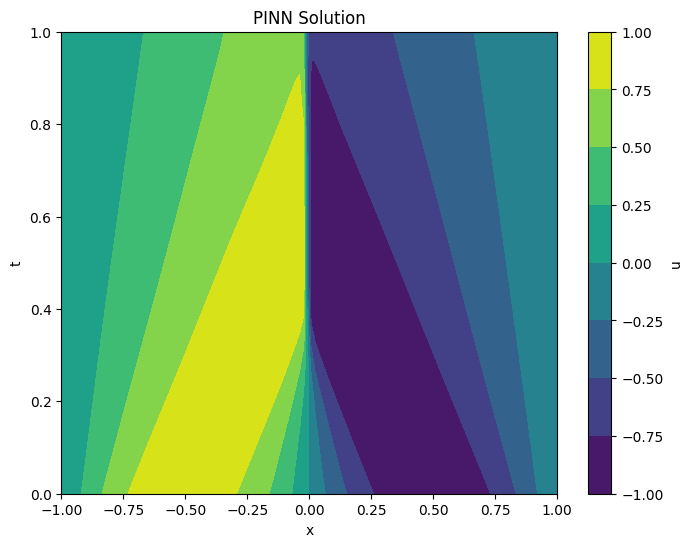

In [139]:
# Evaluate the model

x_test = torch.linspace(-1,1,130, requires_grad = False).to(device).view(-1,1)
t_test = torch.linspace(0,1,130, requires_grad = False).to(device).view(-1,1)
x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'xy')
x_test = x_test.reshape(-1,1)
t_test = t_test.reshape(-1,1)

PINN.eval()

with torch.no_grad():
  u_test = PINN(x_test, t_test)

# Reshape the predicted u values for contour plotting
x_test = x_test.cpu()
t_test = t_test.cpu()
u_test = u_test.cpu()

x_test = x_test.reshape(130,130)
t_test = t_test.reshape(130,130)
u_test = u_test.reshape(130,130)

# Plot the PINN solution as a contour plot

plt.figure(figsize=(8,6))
plt.contourf(x_test, t_test, u_test, cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Solution')

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (16900, 1)

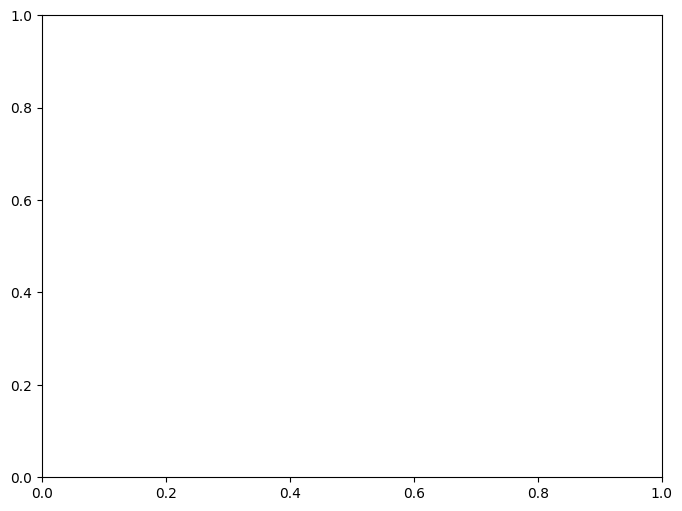

In [ ]:
# # Evaluate the model

# x_test = torch.linspace(-1,1,130, requires_grad = False).to(device).view(-1,1)
# t_test = torch.linspace(0,1,130, requires_grad = False).to(device).view(-1,1)


# # x_test = torch.linspace(-1,1,130, requires_grad = False).view(-1,1)
# # t_test = torch.linspace(0,1,130, requires_grad = False).view(-1,1)
# x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'xy')
# x_test = x_test.reshape(-1,1)
# t_test = t_test.reshape(-1,1)

# PINN.eval()

# with torch.no_grad():
#   u_test = PINN(x_test, t_test)

# # Reshape the predicted u values for contour plotting
# x_test = x_test.cpu()
# t_test = t_test.cpu()
# u_test = u_test.cpu()

# # x_test = x_test.reshape(130,130)
# # t_test = t_test.reshape(130,130)
# # u_test = u_test.reshape(130,130)

# # Plot the PINN solution as a contour plot

# plt.figure(figsize=(8,6))
# plt.contourf(x_test, t_test, u_test, cmap='viridis')
# plt.colorbar(label='u')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('PINN Solution')
# plt.show()